# Emulators: Measuring performance

This example illustrates how different neural networks perform in emulating the log-likelihood surface of a time series and in Bayesian inference, using a two-step MCMC procedure with emulator neural networks [Emulated Metropolis MCMC](../sampling/first-example.ipynb).

It follows on from [Emulators: First example](../mcmc/first-example-emulator.ipynb)

Like in the first example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy

class RescaledModel(pints.ForwardModel):
    def __init__(self):
        self.base_model = toy.LogisticModel()
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulate([r, k], times)
    
    def simulateS1(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulateS1([r, k], times)
    
    def n_parameters(self):
        # Return the dimension of the parameter vector
        return 2
    
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]
start_parameters = [0.75, 1.0] # rescaled true parameters

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)
range_values = max(org_values) - min(org_values)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 0.05 * range_values
print("Gaussian noise:", noise)
values = org_values + np.random.normal(0, noise, org_values.shape)
values = org_values + np.random.normal(0, noise, org_values.shape)

Gaussian noise: 24.898095903089327


Using matplotlib and seaborn (optional - for styling), I look at the noisy time series I just simulated:

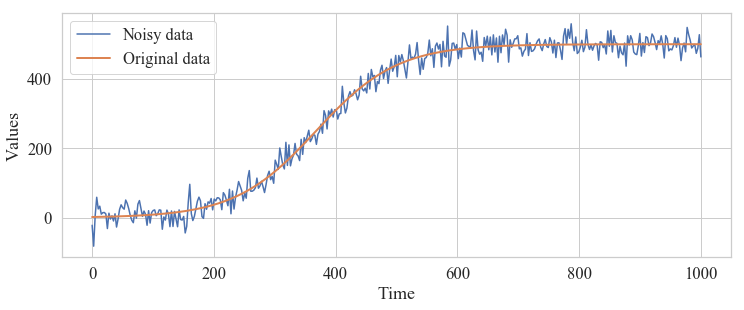

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='deep', font='Times New Roman', 
        font_scale=1.5, color_codes=True, rc={"grid.linewidth": 1})
plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Original data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
model = RescaledModel()
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create (rescaled) bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.5, 0.8], [1.0, 1.2])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions, using the rescaled true parameters:

In [12]:
x0 = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05,
    np.array(start_parameters) * 1.15,
]

## Creating training data

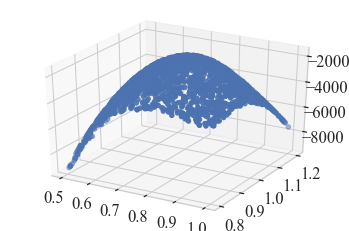

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.model_selection import train_test_split

input_parameters = log_prior.sample(2000)
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, list(likelihoods))
plt.show()

## Training various NNs with different setups

In [14]:
layers = list(range(1, 11, 1))
neurons = [ 2**j for j in range(4,6+1) ]
epochs = 1000
print("NN layers:", layers)
print("NN hidden units:", neurons)

# Compute all possible permutations of NN parameters
hyperparams = [[i, j] for i in layers  
                      for j in neurons] 

print ("All possible layer and hidden units permutations are: " + str(hyperparams)) 
print(len(hyperparams), "sets of hyperparameters")

NN layers: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
NN hidden units: [16, 32, 64]
All possible layer and hidden units permutations are: [[1, 16], [1, 32], [1, 64], [2, 16], [2, 32], [2, 64], [3, 16], [3, 32], [3, 64], [4, 16], [4, 32], [4, 64], [5, 16], [5, 32], [5, 64], [6, 16], [6, 32], [6, 64], [7, 16], [7, 32], [7, 64], [8, 16], [8, 32], [8, 64], [9, 16], [9, 32], [9, 64], [10, 16], [10, 32], [10, 64]]
30 sets of hyperparameters


In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats

sigma0 = [[ 1.01547594e-05, -2.58358260e-06], [-2.58358260e-06,  1.22093040e-05]]
scaling_factors = [1/50, 500]
runs = 5

mapes = []
rhats_nn = []
rhats_emu = []
w_distances_nn1 = []
w_distances_nn2 = []
w_distances_nn3 = []
w_distances_emu1 = []
w_distances_emu2 = []
w_distances_emu3 = []
acceptance_rates1 = []
acceptance_rates2 = []
acceptance_rates3 = []

# Run standard Metropolis Hastings MCMC
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, x0, sigma0=sigma0, method=pints.MetropolisRandomWalkMCMC)
mcmc.set_max_iterations(30000) # Add stopping criterion
mcmc.set_log_to_screen(False) # Disable logging mode
metropolis_chains = mcmc.run()
# Revert scaling
metropolis_chains_rescaled = np.copy(metropolis_chains)
metropolis_chain_rescaled = metropolis_chains_rescaled[0]
metropolis_chain_rescaled = metropolis_chain_rescaled[10000:]
metropolis_chains = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] 
                              for chain in metropolis_chains])
metropolis_chain = metropolis_chains[0][10000:]
metropolis_chain2 = metropolis_chains[1][10000:]
metropolis_chain3 = metropolis_chains[2][10000:]
# Split chains by parameter for computing Wasserstein distance
metropolis_chain_r = np.array([sample[0] for sample in metropolis_chain])
metropolis_chain_k = np.array([sample[1] for sample in metropolis_chain])
metropolis_chain2_r = np.array([sample[0] for sample in metropolis_chain2])
metropolis_chain2_k = np.array([sample[1] for sample in metropolis_chain2])
metropolis_chain3_r = np.array([sample[0] for sample in metropolis_chain3])
metropolis_chain3_k = np.array([sample[1] for sample in metropolis_chain3])
# Check convergence using rhat criterion
rhat = pints.rhat_all_params(metropolis_chains_rescaled[:, 10000:, :])

# Create a number of splits along each axis
test_splits = 50
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
model_prediction = pints.predict_grid(log_likelihood, test_data)

for i, p in enumerate(hyperparams):
    print("Testing NN with parameters (layers, neurons):", p)
    mape = 0
    w_distance_r_nn, w_distance_k_nn = 0, 0
    w_distance_r_emu, w_distance_k_emu = 0, 0
    w_distance_r_nn2, w_distance_k_nn2 = 0, 0
    w_distance_r_emu2, w_distance_k_emu2 = 0, 0
    w_distance_r_nn3, w_distance_k_nn3 = 0, 0
    w_distance_r_emu3, w_distance_k_emu3 = 0, 0
    rates1 = [0, 0, 0]
    rates2 = [0, 0, 0]
    rates3 = [0, 0, 0]
    
    for n in range(runs):
        print("    Run", n+1, "/", runs)
        # Train NN with given parameters
        emu = pints.MultiLayerNN(problem, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
        emu.set_parameters(layers=p[0], neurons=p[1], hidden_activation='relu', activation='linear', learning_rate=0.0001)
        hist = emu.fit(epochs=epochs, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
        log_posterior_emu = pints.LogPosterior(emu, log_prior)
        print("    Done in", len(hist.history['loss']), "epochs")

        # Compute mean abs. percentage error between likelihood surfaces
        emu_prediction = pints.predict_grid(emu, test_data)
        mape += np.mean(np.abs((model_prediction - emu_prediction) / model_prediction))    

        # Run Metropolis Hastings MCMC using NN posterior
        # Create mcmc routine
        mcmc = pints.MCMCController(log_posterior_emu, 3, x0, sigma0=sigma0, method=pints.MetropolisRandomWalkMCMC)
        mcmc.set_max_iterations(30000) # Add stopping criterion
        mcmc.set_log_to_screen(False) # Disable logging mode
        chains_emu = mcmc.run()
        # Revert scaling
        chains_emu_rescaled = np.copy(chains_emu)
        chain_emu_rescaled = chains_emu_rescaled[0]
        chain_emu_rescaled = chain_emu_rescaled[10000:]
        chains_emu = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] for chain in chains_emu])
        chain_emu = chains_emu[0][10000:]
        chain_emu2 = chains_emu[1][10000:]
        chain_emu3 = chains_emu[2][10000:]
        # Check convergence using rhat criterion
        rhat = pints.rhat_all_params(chains_emu_rescaled[:, 10000:, :])
        rhats_nn.append(rhat)
    
    
        # Run 2-step Metropolis Hastings MCMC
        # Create mcmc routine
        mcmc = pints.MCMCController(log_posterior_emu, 3, x0, sigma0=sigma0, method=pints.EmulatedMetropolisMCMC, f=log_posterior)
        mcmc.set_max_iterations(30000) # Add stopping criterion
        mcmc.set_log_to_screen(False) # Disable logging mode
        emulated_chains = mcmc.run()
        # Get acceptance rates per stage of the 2-step procedure
        rates = mcmc.acceptance_rates()
        rates1 = [sum(r) for r in zip(rates1, rates[0])] # Chain 1
        rates2 = [sum(r) for r in zip(rates2, rates[1])] # Chain 2
        rates3 = [sum(r) for r in zip(rates3, rates[2])] # Chain 3
        # Revert scaling
        emulated_chains_rescaled = np.copy(emulated_chains)
        emulated_chain_rescaled = emulated_chains_rescaled[0]
        emulated_chain_rescaled = emulated_chain_rescaled[10000:]
        emulated_chains = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] 
                                    for chain in emulated_chains])
        emulated_chain = emulated_chains[0][10000:]
        emulated_chain2 = emulated_chains[1][10000:]
        emulated_chain3 = emulated_chains[2][10000:]
        # Check convergence using rhat criterion
        rhat = pints.rhat_all_params(emulated_chains_rescaled[:, 10000:, :])
        rhats_emu.append(rhat)

        # Split chains by parameter for computing Wasserstein distance
        chain_emu_r = np.array([sample[0] for sample in chain_emu])
        chain_emu_k = np.array([sample[1] for sample in chain_emu])
        chain2_emu_r = np.array([sample[0] for sample in chain_emu2])
        chain2_emu_k = np.array([sample[1] for sample in chain_emu2])
        chain3_emu_r = np.array([sample[0] for sample in chain_emu3])
        chain3_emu_k = np.array([sample[1] for sample in chain_emu3])
        emulated_chain_r = np.array([sample[0] for sample in emulated_chain])
        emulated_chain_k = np.array([sample[1] for sample in emulated_chain])
        emulated_chain2_r = np.array([sample[0] for sample in emulated_chain2])
        emulated_chain2_k = np.array([sample[1] for sample in emulated_chain2])
        emulated_chain3_r = np.array([sample[0] for sample in emulated_chain3])
        emulated_chain3_k = np.array([sample[1] for sample in emulated_chain3])

        # Compute Wasserstein distances
        w_distance_r_nn = stats.wasserstein_distance(metropolis_chain_r, chain_emu_r)
        w_distance_k_nn = stats.wasserstein_distance(metropolis_chain_k, chain_emu_k)
        w_distance_r_emu = stats.wasserstein_distance(metropolis_chain_r, emulated_chain_r)
        w_distance_k_emu = stats.wasserstein_distance(metropolis_chain_k, emulated_chain_k)
        w_distance_r_nn2 = stats.wasserstein_distance(metropolis_chain2_r, chain2_emu_r)
        w_distance_k_nn2 = stats.wasserstein_distance(metropolis_chain2_k, chain2_emu_k)
        w_distance_r_emu2 = stats.wasserstein_distance(metropolis_chain2_r, emulated_chain2_r)
        w_distance_k_emu2 = stats.wasserstein_distance(metropolis_chain2_k, emulated_chain2_k)
        w_distance_r_nn3 = stats.wasserstein_distance(metropolis_chain3_r, chain3_emu_r)
        w_distance_k_nn3 = stats.wasserstein_distance(metropolis_chain3_k, chain3_emu_k)
        w_distance_r_emu3 = stats.wasserstein_distance(metropolis_chain3_r, emulated_chain3_r)
        w_distance_k_emu3 = stats.wasserstein_distance(metropolis_chain3_k, emulated_chain3_k)
    
    w_distances_nn1.append((w_distance_r_nn/runs, w_distance_k_nn/runs))
    w_distances_nn2.append((w_distance_r_nn2/runs, w_distance_k_nn2/runs))
    w_distances_nn3.append((w_distance_r_nn3/runs, w_distance_k_nn3/runs))

    w_distances_emu1.append((w_distance_r_emu/runs, w_distance_k_emu/runs))
    w_distances_emu2.append((w_distance_r_emu2/runs, w_distance_k_emu2/runs))
    w_distances_emu3.append((w_distance_r_emu3/runs, w_distance_k_emu3/runs))
    
    mapes.append(mape/runs)
    acceptance_rates1.append([r/runs for r in rates1]) # Averages for chain 1
    acceptance_rates2.append([r/runs for r in rates2]) # Averages for chain 2
    acceptance_rates3.append([r/runs for r in rates3]) # Averages for chain 3

    print(p, mape/runs, (w_distance_r_nn/runs, w_distance_k_nn/runs), [r/runs for r in rates1])
    

Testing NN with parameters (layers, neurons): [1, 16]
    Run 1 / 5
    Done in 1000 epochs
    Run 2 / 5
    Done in 1000 epochs
    Run 3 / 5
    Done in 1000 epochs
    Run 4 / 5
    Done in 1000 epochs
    Run 5 / 5
    Done in 1000 epochs
[1, 16] 0.05135521830698062 (2.1873848291167466e-05, 0.714078094608959) [0.040700000000000056, 0.4984466666666677, 0.0821807512315231]
Testing NN with parameters (layers, neurons): [1, 32]
    Run 1 / 5
    Done in 1000 epochs
    Run 2 / 5
    Done in 1000 epochs
    Run 3 / 5
    Done in 1000 epochs
    Run 4 / 5
    Done in 1000 epochs
    Run 5 / 5
    Done in 1000 epochs
[1, 32] 0.030483336503486926 (9.66981320959932e-05, 0.7418999058361246) [0.10584000000000042, 0.5053000000000009, 0.2036478337119422]
Testing NN with parameters (layers, neurons): [1, 64]
    Run 1 / 5
    Done in 762 epochs
    Run 2 / 5
    Done in 736 epochs
    Run 3 / 5
    Done in 785 epochs
    Run 4 / 5
    Done in 861 epochs
    Run 5 / 5
    Done in 829 epochs
[1, 

    Done in 51 epochs
    Run 2 / 5
    Done in 44 epochs
    Run 3 / 5
    Done in 64 epochs
    Run 4 / 5
    Done in 47 epochs
    Run 5 / 5
    Done in 50 epochs
[8, 32] 0.018986926666591332 (1.7116678972242846e-05, 1.7063282868383602) [0.22043333333333326, 0.5933133333333298, 0.3752762070769237]
Testing NN with parameters (layers, neurons): [8, 64]
    Run 1 / 5
    Done in 32 epochs
    Run 2 / 5
    Done in 31 epochs
    Run 3 / 5
    Done in 25 epochs
    Run 4 / 5
    Done in 31 epochs
    Run 5 / 5
    Done in 36 epochs
[8, 64] 0.030007498259883268 (9.732482363650241e-06, 0.8744530731960121) [0.20924666666666783, 0.5707133333333345, 0.3715182609026566]
Testing NN with parameters (layers, neurons): [9, 16]
    Run 1 / 5
    Done in 65 epochs
    Run 2 / 5
    Done in 68 epochs
    Run 3 / 5
    Done in 85 epochs
    Run 4 / 5
    Done in 77 epochs
    Run 5 / 5
    Done in 89 epochs
[9, 16] 0.014858813818610752 (5.879316864005141e-05, 1.307503556604499) [0.1865666666666672, 0.

In [18]:
mapes[:5]

[0.05135521830698062,
 0.030483336503486926,
 0.010779825615833486,
 0.042156263951618506,
 0.02490941469188141]

In [42]:
w_distances_nn1[:5]

[(2.1873848291167466e-05, 0.714078094608959),
 (9.66981320959932e-05, 0.7418999058361246),
 (4.481290807152508e-05, 0.6256633019368418),
 (0.0001225323440857377, 5.277703127109052),
 (0.00017574160720993027, 1.418463809743559)]

In [43]:
w_distances_nn2[:5]

[(2.1874611023665825e-05, 0.7265758467898662),
 (9.700157427117223e-05, 0.7305520558487337),
 (4.614770045700983e-05, 0.5944146695699801),
 (0.00012237484481848033, 5.27336895157296),
 (0.00018144440609692657, 1.4772243910014837)]

In [21]:
acceptance_rates1[:5]
#self._acceptance, self._acceptance1, self._acceptance2

[[0.040700000000000056, 0.4984466666666677, 0.0821807512315231],
 [0.10584000000000042, 0.5053000000000009, 0.2036478337119422],
 [0.2524466666666664, 0.5943666666666652, 0.4143860005069991],
 [0.062299999999999967, 0.5346733333333313, 0.11446781863448093],
 [0.0894866666666668, 0.5098066666666703, 0.17516817349954167]]

In [22]:
chain1_acceptance_rates2 = [r[2] for r in acceptance_rates1]
chain2_acceptance_rates2 = [r[2] for r in acceptance_rates2]
chain3_acceptance_rates2 = [r[2] for r in acceptance_rates3]
chain1_acceptance_rates2[:5]

[0.0821807512315231,
 0.2036478337119422,
 0.4143860005069991,
 0.11446781863448093,
 0.17516817349954167]

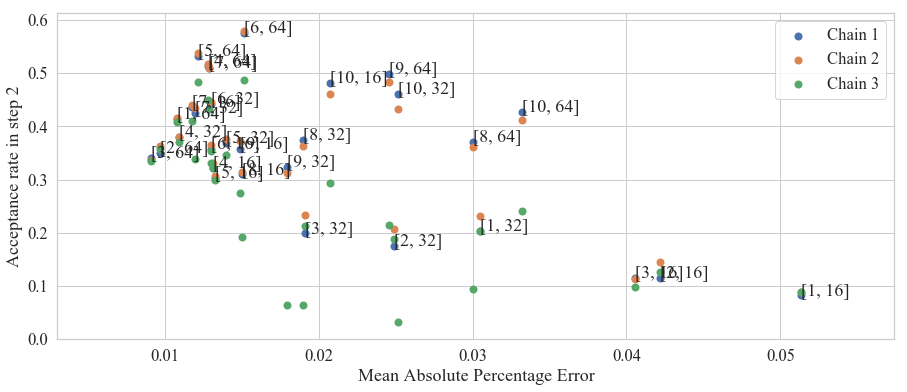

In [30]:
sns.set(context='notebook', style='whitegrid', palette='deep', font='Times New Roman', 
        font_scale=1.5, color_codes=True, rc={"grid.linewidth": 1})
fig, ax = plt.subplots(figsize=(15,6))
plt.xlabel('Mean Absolute Percentage Error')
plt.ylabel('Acceptance rate in step 2')
ax.axhline(y=0.565, ls='--',lw=2, c='k', alpha=0.7)
ax.scatter(mapes, chain1_acceptance_rates2, lw=2, label='Chain 1')
ax.scatter(mapes, chain2_acceptance_rates2, lw=2, label='Chain 2')
ax.scatter(mapes, chain3_acceptance_rates2, lw=2, label='Chain 3')
for i, txt in enumerate(hyperparams):
    ax.annotate(txt, (mapes[i], chain1_acceptance_rates2[i]))
plt.legend()
plt.show()

In [36]:
# Extract Wasserstein distances by parameter
w_distances_r1 = [d[0] for d in w_distances_nn1]
w_distances_k1 = [d[1] for d in w_distances_nn1]
w_distances_sum1 = [r+k for r, k in zip(w_distances_r1, w_distances_k1)]

[0.7265977214008899,
 0.7306490574230049,
 0.5944608172704371,
 5.273491326417778,
 1.4774058354075807]

In [51]:
w_distances_r = []
w_distances_k = []
w_distances_sum = []

for dist in [w_distances_nn1, w_distances_nn2, w_distances_nn3]:
    # Extract Wasserstein distances by parameter
    dist_r = [d[0] for d in dist]
    dist_k = [d[1] for d in dist]
    # Compute sum of rescaled distances
    scaler_r = MinMaxScaler()
    scaler_k = MinMaxScaler()
    dist_r = scaler_r.fit_transform(np.array(dist_r).reshape(-1, 1))
    dist_k = scaler_k.fit_transform(np.array(dist_k).reshape(-1, 1))
    w_distances_r.append(list(dist_r))
    w_distances_k.append(list(dist_k))
    w_distances_sum.append([r+k for r, k in zip(list(dist_r), list(dist_k))])

w_distances_sum[0]

30

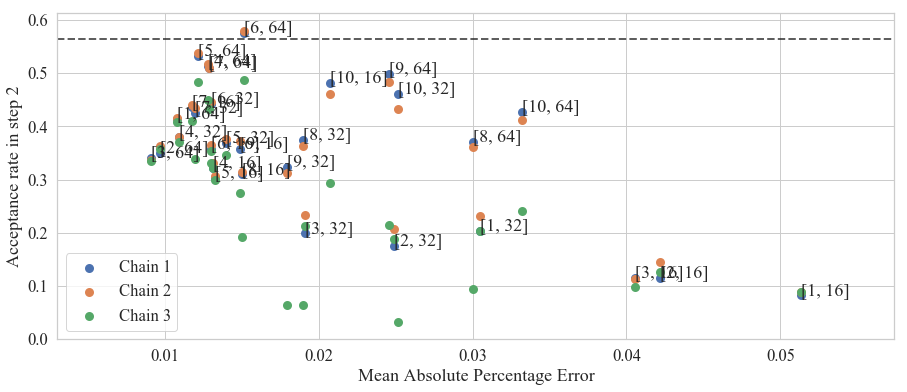

In [74]:
sns.set(context='notebook', style='whitegrid', palette='deep', font='Times New Roman', 
        font_scale=1.5, color_codes=True, rc={"grid.linewidth": 1})
fig, ax = plt.subplots(figsize=(15,6))
plt.xlabel('Mean Absolute Percentage Error')
plt.ylabel('Acceptance rate in step 2')
ax.axhline(y=0.565, ls='--',lw=2, c='k', alpha=0.7)
ax.scatter(mapes, chain1_acceptance_rates2, lw=3, label='Chain 1')
ax.scatter(mapes, chain2_acceptance_rates2, lw=3, label='Chain 2')
ax.scatter(mapes, chain3_acceptance_rates2, lw=3, label='Chain 3')
for i, txt in enumerate(hyperparams):
    ax.annotate(txt, (mapes[i], chain1_acceptance_rates2[i]))
plt.legend()
plt.show()

fig.savefig("figures/nn-comparisons/mae.png", bbox_inches='tight', dpi=600)

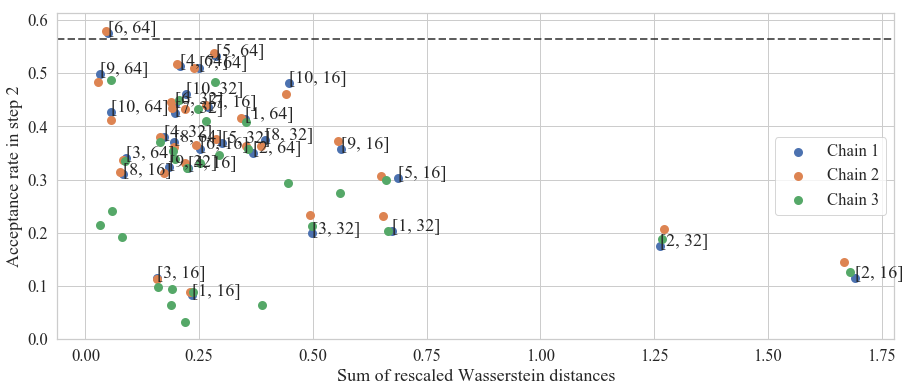

MemoryError: In RendererAgg: Out of memory

In [75]:
sns.set(context='notebook', style='whitegrid', palette='deep', font='Times New Roman', 
        font_scale=1.5, color_codes=True, rc={"grid.linewidth": 1})
fig, ax = plt.subplots(figsize=(15,6))
plt.xlabel('Sum of rescaled Wasserstein distances')
plt.ylabel('Acceptance rate in step 2')
ax.axhline(y=0.565, ls='--',lw=2, c='k', alpha=0.7)
ax.scatter(w_distances_sum[0], chain1_acceptance_rates2, lw=3, label='Chain 1')
ax.scatter(w_distances_sum[1], chain2_acceptance_rates2, lw=3, label='Chain 2')
ax.scatter(w_distances_sum[2], chain3_acceptance_rates2, lw=3, label='Chain 3')
for i, txt in enumerate(hyperparams):
    ax.annotate(txt, (w_distances_sum[0][i], chain1_acceptance_rates2[i]))
plt.legend()
plt.show()

fig.savefig("figures/nn-comparisons/rescaled-wasserstein-sum.png", bbox_inches='tight', dpi=600)

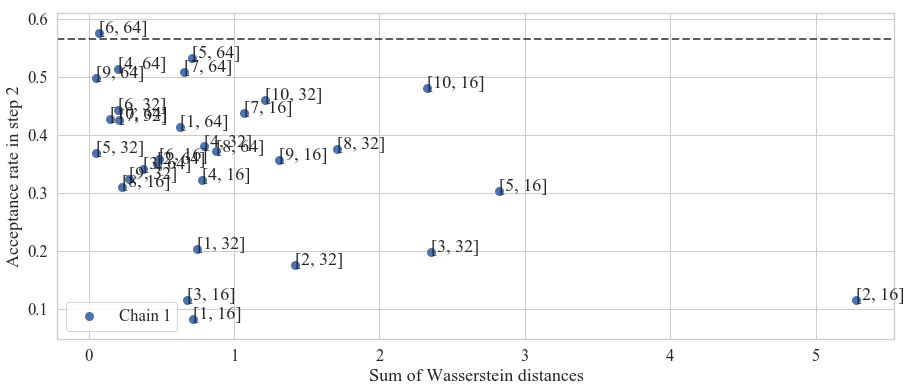

MemoryError: In RendererAgg: Out of memory

In [76]:
sns.set(context='notebook', style='whitegrid', palette='deep', font='Times New Roman', 
        font_scale=1.5, color_codes=True, rc={"grid.linewidth": 1})
fig, ax = plt.subplots(figsize=(15,6))
plt.xlabel('Sum of Wasserstein distances')
plt.ylabel('Acceptance rate in step 2')
ax.axhline(y=0.565, ls='--',lw=2, c='k', alpha=0.7)
ax.scatter(w_distances_sum1, chain1_acceptance_rates2, lw=3, label='Chain 1')
for i, txt in enumerate(hyperparams):
    ax.annotate(txt, (w_distances_sum1[i], chain1_acceptance_rates2[i]))
plt.legend()
plt.show()

fig.savefig("figures/nn-comparisons/wasserstein-sum.png", bbox_inches='tight', dpi=600)